# 单发多框检测（SSD）

类别预测层

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)#类别预测，输出通道对应每个像素生成锚框的类别，图片高宽不变

边界框预测层

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)#对每个边界框预测四个偏移量

连结多尺度的预测

In [3]:
def forward(x, block):#定义预测层
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))#5个锚框，10类
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))#3个锚框，10类
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)#交换维度到0,2，3,1（把通道数，也就是预测结果放到最后一维）
#然后从一维展平，展平后为二维的张量，分别为batch_size和预测结果
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)
#将不同预测结果拼接在一起
concat_preds([Y1, Y2]).shape#55X20X20+33X10X10

torch.Size([2, 25300])

高和宽减半块

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))#3X3卷积，高宽不变
        blk.append(nn.BatchNorm2d(out_channels))#batchnorm层
        blk.append(nn.ReLU())#relu激活函数
        in_channels = out_channels#通道数不变，再循环一遍
    blk.append(nn.MaxPool2d(2))#最大池化层，高宽减半
    return nn.Sequential(*blk)#两个3X3卷积，两个batchnorm,加一个2X2最大池化层,高宽减半

forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

基本网络块

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]#通道数变化规律
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)#构建基本网络，由三个高宽减半块构成

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape#通道数变为64，高宽均缩小八倍

torch.Size([2, 64, 32, 32])

完整的单发多框检测模型由五个模块组成

In [9]:
def get_blk(i):#不同的输入返回不同的网络
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))#自适应池化，输出（H,W）=(1,1)
    else:
        blk = down_sample_blk(128, 128)
    return blk

为每个块定义前向传播

In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)#前向传播
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)#对Y给定锚框
    cls_preds = cls_predictor(Y)#对Y类别预测
    bbox_preds = bbox_predictor(Y)#对Y边界框预测
    return (Y, anchors, cls_preds, bbox_preds)#返回

超参数

In [11]:
#给定了5组大小和比例，每组都是产生4个锚框，对应SSD中每个网络块要预测的超参数
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

定义完整的模型

In [12]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]#对应每个网络块输出通道数
        for i in range(5):#定义每个网络块的类别和锚框预测
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)#合并锚框
        cls_preds = concat_preds(cls_preds)#合并预测
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)#输出（batch,锚框数，类别）
        bbox_preds = concat_preds(bbox_preds)#合并预测锚框
        return anchors, cls_preds, bbox_preds

创建一个模型实例，然后使用它
执行前向传播

In [13]:
net = TinySSD(num_classes=1)#一类，使用的是香蕉数据集
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)#预测

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


读取
香蕉检测数据集

In [14]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)#加载data_iter

read 1000 training examples
read 100 validation examples


初始化其参数并定义优化算法

In [15]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)#在GPU上训练
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)#使用随机梯度下降

定义损失函数和评价函数

In [17]:
cls_loss = nn.CrossEntropyLoss(reduction='none')#对类别预测，reduction='none'对batch中各样本的loss，返回列表
bbox_loss = nn.L1Loss(reduction='none')#锚框预测使用L1loss,因为锚框是回归问题

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)#对每个样本的损失求平均
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)#只对预测含有物体的锚框计算损失
    return cls + bbox#返回损失和

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())#计算预测类别正确数

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())#计算预测锚框正确数

训练模型

class err 3.25e-03, bbox mae 3.13e-03
5044.0 examples/sec on cuda:0


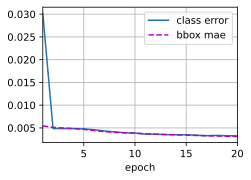

In [18]:
num_epochs, timer = 20, d2l.Timer()#迭代20次
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])#显示图像
net = net.to(device)#网络转移到GPU上
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()#训练模式，会更新梯度
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()#反向传播
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

预测目标

In [20]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()
#使用下面的multibox_detection函数，我们可以根据锚框及其预测偏移量得到预测边界框。然后，通过非极大值抑制来移除相似的预测边界框。
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))#传入网络
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

筛选所有置信度不低于0.9的边界框，做为最终输出

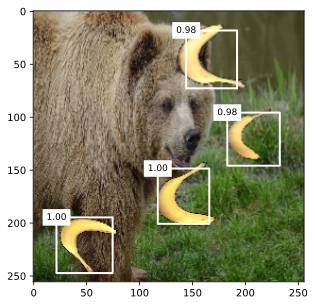

In [21]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:#低于阈值，不输出
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

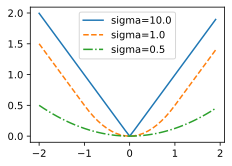

In [22]:
def smooth_l1(data, scalar):#平滑L1范数损失
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

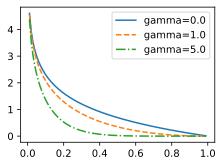

In [23]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();